In [1]:
import os
import gc
import glob
import random
import librosa
import IPython.display
import librosa.display
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib as plt
import IPython.display as ipd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from scipy.signal import butter, lfilter
from tensorflow.keras import models, layers, Input
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Reshape, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1,l2
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold

In [2]:
DATA_type = 'MFCC_rnn'
Model_name = 'RNN_MFCC'
Train_data=np.load(f'{DATA_type}/Train_data.npy')
Train_lebel=np.load(f'{DATA_type}/Train_lebel.npy')
Val_data=np.load(f'{DATA_type}/Val_data.npy')
Val_lebel=np.load(f'{DATA_type}/Val_lebel.npy')
print(np.shape(Train_data))
print(np.shape(Train_lebel))
print(np.shape(Val_data))
print(np.shape(Val_lebel))

(5, 8000, 44, 20)
(5, 8000)
(5, 2000, 44, 20)
(5, 2000)


In [3]:
def create_model():
    model = models.Sequential([
        Input(shape=np.shape(Train_data[0][0])),
        layers.LSTM(64, return_sequences=True),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.LSTM(32, return_sequences=False),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(2, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = create_model()
model.summary()

class MemoryBestWeights(Callback):
    def __init__(self, monitor='val_loss', mode='min'):
        super().__init__()
        self.monitor = monitor
        self.mode = mode
        
        if self.mode == 'min':
            self.best = np.Inf
            self.monitor_op = np.less
        else:
            self.best = -np.Inf
            self.monitor_op = np.greater
        
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:return
        if self.monitor_op(current, self.best):
            self.best = current
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs=None):
        if self.best_weights is not None:
            self.model.set_weights(self.best_weights)
            print(f"Restored best weights from {self.monitor} = {self.best:.4f}")
        else:print("No improvement was tracked; model weights not restored.")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 44, 64)            21760     
                                                                 
 batch_normalization (BatchN  (None, 44, 64)           256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 44, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 32)                0

In [4]:
accuracy_scores,precision_scores,recall_scores,f1_scores,auc_scores,histories,train_classes,val_classes = [],[],[],[],[],[],[],[]
cm_array = np.empty((0, 2, 2), dtype=int)
kf = KFold(n_splits=5, shuffle=True, random_state=958)

best_acc = 0
best_fold = None

for i in range(5):
    for train_idx, val_idx in list(kf.split(Train_data[i])):
        train_x, val_x = Train_data[i][train_idx], Train_data[i][val_idx]
        train_y, val_y = Train_lebel[i][train_idx], Train_lebel[i][val_idx]

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    memory_best = MemoryBestWeights(monitor='val_loss', mode='min')
    
    model = create_model()
    print(f'--- Fold {i+1} training ---')
    history = model.fit(train_x, train_y, validation_data=(val_x, val_y),
                        epochs=100, batch_size=32, callbacks=[reduce_lr, memory_best], verbose=1)

    y_pred_prob = model.predict(Val_data[i])
    y_pred = (y_pred_prob > 0.5).astype("int32")
    if len(Val_lebel[i].shape) > 1 and Val_lebel[i].shape[1] > 1 : y_val_binary = np.argmax(Val_lebel[i], axis=1)
    else : y_val_binary = Val_lebel[i]
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1 : y_pred_binary = np.argmax(y_pred, axis=1)
    else : y_pred_binary = y_pred
    
    accuracy = model.evaluate(Val_data[i], Val_lebel[i], verbose=0)[1]
    precision = precision_score(y_val_binary, y_pred_binary, average='binary')
    recall = recall_score(y_val_binary, y_pred_binary, average='binary')
    f1 = f1_score(y_val_binary, y_pred_binary, average='binary')
    auc = roc_auc_score(y_val_binary, y_pred_prob[:, 1] if y_pred_prob.shape[1] > 1 else y_pred_prob)
    
    histories.append(history)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    auc_scores.append(auc)

    cm = confusion_matrix(y_val_binary, y_pred_binary)
    cm_array = np.append(cm_array, [cm], axis=0)
    IPython.display.clear_output(wait=True)

    if accuracy > best_acc:
        best_acc = accuracy
        best_fold = i+1
        best_model_weights = model.get_weights()

print('--- Model Train/Validation Finished ---')

--- Model Train/Validation Finished ---


In [5]:
print("--- K-Fold Cross-Validation Results ---")
print(f"Accuracy:  {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")
print(f"Precision: {np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}")
print(f"Recall:    {np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}")
print(f"F1-Score:  {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"AUC-ROC:   {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")
print(f"\nBest fold was Fold {best_fold} with accuracy: {best_acc:.4f}")

--- K-Fold Cross-Validation Results ---
Accuracy:  0.8464 ± 0.0115
Precision: 0.8161 ± 0.0103
Recall:    0.8929 ± 0.0109
F1-Score:  0.8527 ± 0.0098
AUC-ROC:   0.9309 ± 0.0090

Best fold was Fold 2 with accuracy: 0.8590


Best Model Metric


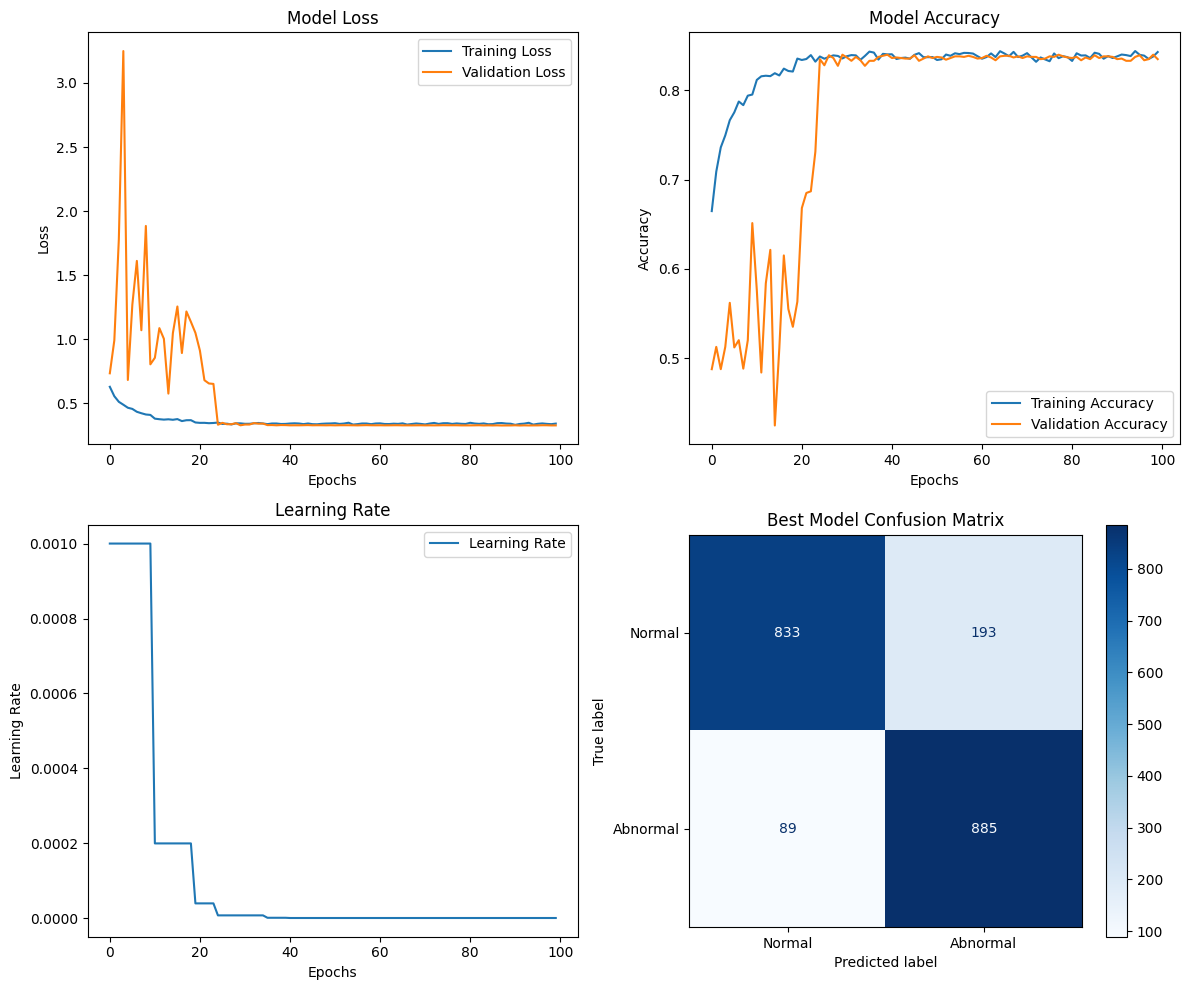

In [6]:
print("Best Model Metric")
best_history = histories[best_fold - 1]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(best_history.history['loss'], label='Training Loss')
axes[0, 0].plot(best_history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

axes[0, 1].plot(best_history.history['accuracy'], label='Training Accuracy')
axes[0, 1].plot(best_history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 1].set_title('Model Accuracy')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

if 'lr' in best_history.history:
    axes[1, 0].plot(best_history.history['lr'], label='Learning Rate')
elif 'learning_rate' in best_history.history:
    axes[1, 0].plot(best_history.history['learning_rate'], label='Learning Rate')
axes[1, 0].set_title('Learning Rate')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].legend()

cm = cm_array[best_fold - 1]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues, ax=axes[1, 1])
axes[1, 1].set_title("Best Model Confusion Matrix")

plt.tight_layout()
plt.show()

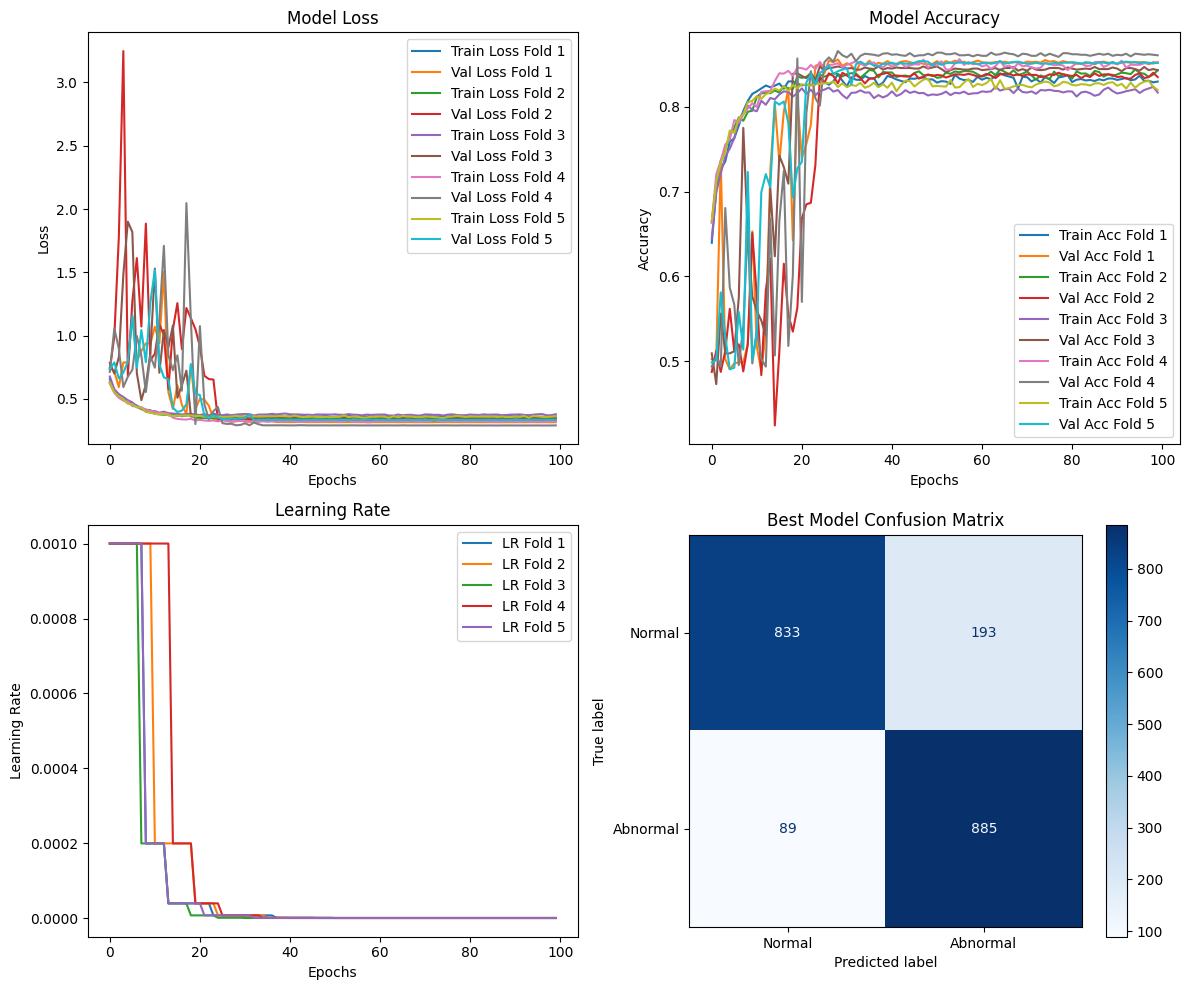

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, h in enumerate(histories):
    axes[0, 0].plot(h.history['loss'], label=f'Train Loss Fold {i+1}')
    axes[0, 0].plot(h.history['val_loss'], label=f'Val Loss Fold {i+1}')
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

for i, h in enumerate(histories):
    axes[0, 1].plot(h.history['accuracy'], label=f'Train Acc Fold {i+1}')
    axes[0, 1].plot(h.history['val_accuracy'], label=f'Val Acc Fold {i+1}')
axes[0, 1].set_title('Model Accuracy')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

for i, h in enumerate(histories):
    if 'lr' in h.history:
        axes[1, 0].plot(h.history['lr'], label=f'LR Fold {i+1}')
    elif 'learning_rate' in h.history:
        axes[1, 0].plot(h.history['learning_rate'], label=f'LR Fold {i+1}')
axes[1, 0].set_title('Learning Rate')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].legend()

cm = cm_array[best_fold - 1]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues, ax=axes[1, 1])
axes[1, 1].set_title("Best Model Confusion Matrix")

plt.tight_layout()
plt.show()

In [8]:
model.save(f'_model/{Model_name}.h5')